## Submanifold Closure

In [3]:
%load_ext autoreload
import jax.numpy as jnp
from jaxtyping import Array
import matplotlib.pyplot as plt
import dynamiqs as dq
import strawberryfields as sf
import os
from jaxpulse.controllers import ControlVector, SinusoidalControl, ConstantControl, FrequencyControl, GaussianControl
from jaxpulse.optimizers import ClosedQuantumSystem, OptimalController
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Drift

In [4]:
alpha = .1
beta = .2
delta = .5+.4j
gamma = .1
epsilon = 1.5 + 2j
def c(v):
    return jnp.conj(v)
H_0 = jnp.array(
    [
        [1.0,       alpha,      beta,       0.0,        0.0],
        [c(alpha),  2,          delta,      0.0,        0.0],
        [c(beta),   c(delta),   3,          gamma,      0.0],
        [0.0,       0.0,        c(gamma),   4,          epsilon],
        [0.0,       0.0,        0.0,        c(epsilon), 5]
    ]
)

### Controls

In [5]:
H_1 = jnp.array(
    [
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  1.0,  0.0,  0.0],
        [0.0,  1.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_2 = jnp.array(
    [
        [0.0,  1.0,  0.0,  0.0,  0.0],
        [1.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_3 = jnp.array(
    [
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  1.0,  0.0],
        [0.0,  0.0,  1.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_M = [H_1, H_2, H_3]
ppc = [3,3,3] # pulse per control
u_M = ControlVector(
    [
        GaussianControl(
            amp=1.0*jnp.ones((ppc[0],)),
            mean=jnp.linspace(3,9,ppc[0]),
            sigma=jnp.ones((ppc[0],))
        ),
        GaussianControl(
            amp=1.0*jnp.ones((ppc[1],)),
            mean=jnp.linspace(2,10,ppc[1]),
            sigma=1.0*jnp.ones((ppc[1],))
        ),
        GaussianControl(
            amp=1.0*jnp.ones((ppc[2],)),
            mean=jnp.linspace(2,12,ppc[2]),
            sigma=1.0*jnp.ones((ppc[2],))
        )
    ]
)

In [6]:
closure_sys = ClosedQuantumSystem(
    H_0=H_0,
    H_M=H_M
)
psi0 = dq.fock(5, 0)
duration=15

## State Exclusion
go to 2, avoid 3,4

In [7]:
# project into 3rd
proj = dq.fock_dm(5,2)
def y_final(y: Array) -> float:
    return 1000*(1 - dq.expect(proj, y))

# don't go above 3
exclude_upper = dq.fock_dm(5,3) #+ dq.fock_dm(5,4)
def y_statewise(y: Array, t: float) -> float:
    return dq.expect(exclude_upper, y) 

In [8]:
controller = OptimalController(
    system=closure_sys,
    controls=u_M,
    y0=psi0,
    duration=duration,
    y_final=y_final,
    y_statewise=y_statewise
)
exp_ops = [dq.number(5),proj]
exp_names = [r"$\langle n \rangle$", r"$\langle 2 \rangle$"]

### Pre-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_60274/3636940499.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


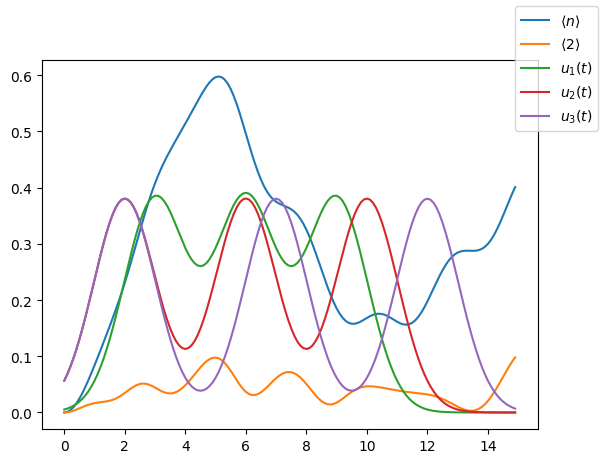

In [9]:
fig_pre, ax_pre = plt.subplots()
controller.plot(ax_pre,
                exp_ops=exp_ops,
                exp_names=exp_names)
fig_pre.legend()
fig_pre.show()

### Train

In [10]:
opt_controller = controller.optimize(
    N_steps=60,
    learning_rate=.1,
    verbosity=1)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


Step: 0 Loss: 904.1051025390625
Step: 1 Loss: 738.5089721679688
Step: 2 Loss: 559.099365234375
Step: 3 Loss: 383.31744384765625
Step: 4 Loss: 241.47396850585938
Step: 5 Loss: 205.90682983398438
Step: 6 Loss: 139.05484008789062
Step: 7 Loss: 57.62140655517578
Step: 8 Loss: 25.034061431884766
Step: 9 Loss: 24.309917449951172
Step: 10 Loss: 20.269939422607422
Step: 11 Loss: 11.912154197692871
Step: 12 Loss: 6.703618049621582
Step: 13 Loss: 5.951200008392334
Step: 14 Loss: 6.735581398010254
Step: 15 Loss: 7.224695205688477
Step: 16 Loss: 7.010807991027832
Step: 17 Loss: 6.272865295410156
Step: 18 Loss: 5.379036903381348
Step: 19 Loss: 4.6034135818481445
Step: 20 Loss: 4.0680975914001465
Step: 21 Loss: 3.7604482173919678
Step: 22 Loss: 3.5692996978759766
Step: 23 Loss: 3.433913230895996
Step: 24 Loss: 3.3498470783233643
Step: 25 Loss: 3.3141930103302
Step: 26 Loss: 3.2936158180236816
Step: 27 Loss: 3.2411489486694336
Step: 28 Loss: 3.1573398113250732
Step: 29 Loss: 3.045551300048828
Step: 3

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_60274/2321787608.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


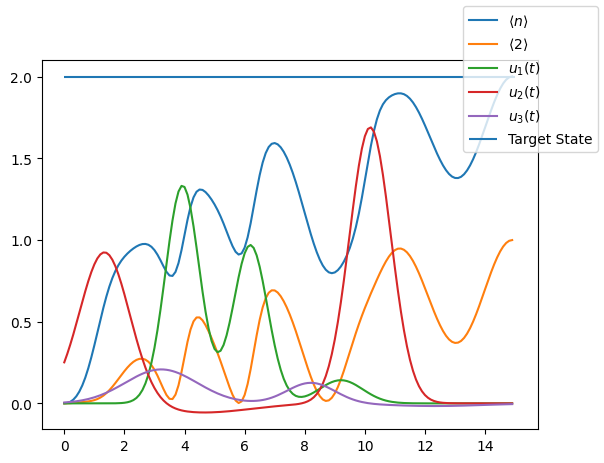

In [11]:
fig_post, ax_post = plt.subplots()
opt_controller.plot(ax_post,
                exp_ops=exp_ops,
                exp_names=exp_names)
ax_post.hlines(y=[2.0],xmin=0,xmax=duration,label="Target State")
fig_post.legend()
fig_post.show()

## Submanfold Stabilization
Go to 3, stay in 2,3

In [12]:
# project into 3rd
proj3 = dq.fock_dm(5,2)
def hit3(y: Array) -> float:
    return 1000*(1 - dq.expect(proj3, y))

# don't leave 2,3
def heaviside(t: float):
    return 1.0*(t > 0)
hold23 = dq.fock_dm(5,1) + dq.fock_dm(5,2)
def stay23(y: Array, t: float) -> float:
    return heaviside(t-5)*(1 - dq.expect(hold23, y))

In [13]:
manifold_controller = OptimalController(
    system=closure_sys,
    controls=u_M,
    y0=psi0,
    duration=duration,
    y_final=hit3,
    y_statewise=stay23
)
m_exp_ops = [dq.number(5),proj3, hold23]
m_exp_names = [r"$\langle n \rangle$", r"$\langle 2 \rangle$", r"$\langle 2, 3 \rangle$"]

### Pre-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_60274/1240978354.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


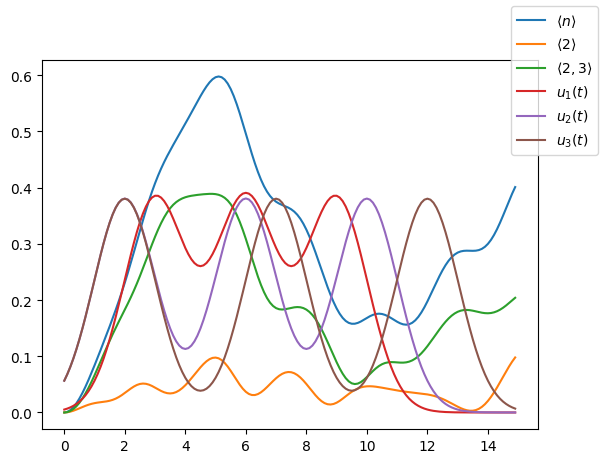

In [14]:
fig_pre, ax_pre = plt.subplots()
manifold_controller.plot(ax_pre,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
fig_pre.legend()
fig_pre.show()

### Train

In [15]:
opt_manifold_controller = manifold_controller.optimize(
    N_steps=80,
    learning_rate=.1,
    verbosity=1
)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


Step: 0 Loss: 984.5432739257812
Step: 1 Loss: 798.3556518554688
Step: 2 Loss: 599.7318725585938
Step: 3 Loss: 422.8996276855469
Step: 4 Loss: 270.8109130859375
Step: 5 Loss: 212.03396606445312
Step: 6 Loss: 142.9620819091797
Step: 7 Loss: 73.8039779663086
Step: 8 Loss: 51.68504333496094
Step: 9 Loss: 47.98231506347656
Step: 10 Loss: 36.55308532714844
Step: 11 Loss: 24.74808120727539
Step: 12 Loss: 20.521900177001953
Step: 13 Loss: 20.647785186767578
Step: 14 Loss: 20.59827423095703
Step: 15 Loss: 19.08928871154785
Step: 16 Loss: 17.270950317382812
Step: 17 Loss: 16.05663299560547
Step: 18 Loss: 15.44285774230957
Step: 19 Loss: 15.00098991394043
Step: 20 Loss: 14.425758361816406
Step: 21 Loss: 13.759729385375977
Step: 22 Loss: 13.207389831542969
Step: 23 Loss: 12.865755081176758
Step: 24 Loss: 12.672289848327637
Step: 25 Loss: 12.532424926757812
Step: 26 Loss: 12.379657745361328
Step: 27 Loss: 12.391671180725098
Step: 28 Loss: 13.392966270446777
Step: 29 Loss: 17.75045394897461
Step: 30

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_60274/3566152222.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


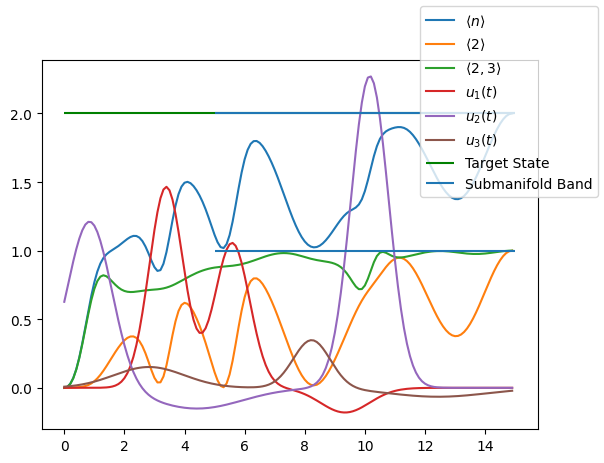

In [16]:
fig_post, ax_post = plt.subplots()
opt_manifold_controller.plot(ax_post,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
ax_post.hlines(y=[2.0],xmin=0,xmax=duration,label="Target State",color='green')
ax_post.hlines(y=[1.0,2.0],xmin=5,xmax=duration,label="Submanifold Band")
fig_post.legend()
fig_post.show()